# Классификация товаров
Основная идея данной части проекта - создание модели, классифицирующей текст-описание товаров в 4 категории (Electronics, Household, Books, and Clothing & Accessories)


## Начало
Подключим необходимые библиотеки, обьявим константы.

In [175]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import ecommercedata as edata
import mymodel
from ecommercedata import text_preprocess
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from gensim.models.fasttext import FastText
import numpy as np
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

In [176]:
NUM_CLASSES = 4
HIDDEN_DIM = 100
LSTM_LAYERS = 1
BATCH_SIZE = 32
IS_BIDIRECTIONAL = True
LR = 1e-4
DEVICE = mymodel.DEVICE

## Подготовка данных
В задаче данные подают в виде csv файла, нам нужно из него получить датасет. 

Основные функции для работы с данными описаны в файле ecommercedata.

In [177]:
category_dict = {'Household': 0, 'Books': 1, 'Clothing & Accessories': 2, 'Electronics' : 3}
category = ['Household', 'Books', 'Clothing & Accessories', 'Electronics']
data, max_len = edata.prepare_data('ecommerceDataset.csv', category_dict)
train_indices, test_indices = edata.train_test_indices(data)
X = data['description']
y = data['category']

In [178]:
vocabulary, vocabulary_to_int = edata.build_vocab(X)
X_tok = edata.huge_tokenize(X, vocabulary_to_int).to(int)
VOCAB_SIZE = len(vocabulary) + 1
EMBEDDING_DIM = 300

### Получение эмбеддинг-матрицы
В данной работе рассмотрим два варианта (будем использовать модель FastText):
 - Скачаем предобученные вектора FastText от Common Crawl.
 - Обучим строить вектора FastText на своем датасете.

Для скачивания предобученных векторов напишем функцию загрузки:

In [179]:
def load_pretrained_fasttext():
        embeddings_index = {}
        f = open('crawl-300d-2M.vec',encoding='utf-8')
        for line in tqdm(f):
            values = line.strip().rsplit(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        
        return embeddings_index

Для обучения FastText, а затем конвертации его векторов в словарь напишем следующую функцию:

In [180]:
def train_load_fasttext(X, train_indices):
    FastText_train_data = list(map(lambda x: x.split(), [X[idx] for idx in train_indices]))
    model_obj = FastText(FastText_train_data, vector_size=EMBEDDING_DIM)
    fsttxt = model_obj.wv
    return fsttxt.key_to_index

Наконец, напишем функцию создания эмбеддинг-матрицы:

In [182]:
def prepare_matrix(embedding_dict):
    embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
    for word, token in vocabulary:
        if word in embedding_dict:
            embedding_vector = embedding_dict[word]
            embedding_matrix[token] = embedding_vector

    return embedding_matrix

In [183]:
embedding_dict_pretrained = load_pretrained_fasttext()     
embedding_dict_trained = train_load_fasttext(X, train_indices)

1999996it [00:51, 38693.91it/s]


### Разделение данных для обучения/тестирования
Разделим данные на тренировочную/валидационную/тестовую выборки.

In [184]:
X_train = [X_tok[idx] for idx in train_indices]
y_train = [y[idx] for idx in train_indices]
X_test = [X_tok[idx] for idx in test_indices]
y_test = [y[idx] for idx in test_indices]

In [185]:
train_dataset = edata.EcommerceDataset(X_train, y_train)
test_dataset = edata.EcommerceDataset(X_test, y_test)
trainval_size = len(train_dataset)
val_size = int(trainval_size * 0.15)
train_size = trainval_size - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
    

In [186]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
valid_loader = DataLoader(val_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

## Модель
Для классификации воспользуемся LSTM сетью с механизмом внимания.
Модель, ее реализация, а также функции обучения и тестирования лежат в файле mymodel.

In [187]:
def load_model(embedding_dict, grad=True):
    model = mymodel.LSTM_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, IS_BIDIRECTIONAL)
    model = model.to(DEVICE)
    embedding_matrix = prepare_matrix(embedding_dict)
    model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
    model.embedding.weight.requirges_grad = grad
    return model

In [188]:
prtr_vec_model = load_model(embedding_dict_pretrained)
fsttxt_vec_model = load_model(embedding_dict_trained)

In [189]:
criterion = nn.NLLLoss()
optimizer_prtr = torch.optim.Adam(prtr_vec_model.parameters(), lr=LR)
optimizer = torch.optim.Adam(fsttxt_vec_model.parameters(), lr=LR)

### Обучение модели
Напишем функцию тестирования и обучения модели:

In [190]:
prtr_vec_model = mymodel.train(prtr_vec_model, train_loader, valid_loader, DEVICE, criterion, optimizer_prtr, 10)
fsttxt_vec_model = mymodel.train(fsttxt_vec_model, train_loader, valid_loader, DEVICE, criterion, optimizer, 10)

Epoch 1/10 finished: train_accuracy = 85.19%, train_loss = 0.4451234789254765
Validation accuracy increased (0.00 --> 85.19).  Saving model ...
Epoch 2/10 finished: train_accuracy = 90.3%, train_loss = 0.32187976175919175
Validation accuracy increased (85.19 --> 90.30).  Saving model ...
Epoch 3/10 finished: train_accuracy = 91.34%, train_loss = 0.29349260311573744
Validation accuracy increased (90.30 --> 91.34).  Saving model ...
Epoch 4/10 finished: train_accuracy = 92.97%, train_loss = 0.25699300025977817
Validation accuracy increased (91.34 --> 92.97).  Saving model ...
Epoch 5/10 finished: train_accuracy = 93.42%, train_loss = 0.24879366355404878
Validation accuracy increased (92.97 --> 93.42).  Saving model ...
Epoch 6/10 finished: train_accuracy = 93.75%, train_loss = 0.23340125314037627
Validation accuracy increased (93.42 --> 93.75).  Saving model ...
Epoch 7/10 finished: train_accuracy = 93.75%, train_loss = 0.23414481464230144
Validation accuracy increased (93.75 --> 93.75).

### Тестирование


Протестируем обе модели, нарисуем метрики.

In [191]:
def make_some_metrics(test_accuracy, test_loss, y_true, y_pred, category_list, modelname):
    print(f'Testing finished for {modelname}: Accuracy =  {test_accuracy}%, Loss = {test_loss} \nClassification report:\n', classification_report(y_true, y_pred, target_names=category_list))
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=category_list)
    cm_display.plot(cmap="BuPu", xticks_rotation=45)

Протестируем модель на тестовой выборке.

Testing finished for pretrained_vectors_model: Accuracy =  94.14%, Loss = 0.2199235462976955 
Classification report:
                         precision    recall  f1-score   support

             Household       0.95      0.94      0.95      2027
                 Books       0.94      0.93      0.94      1073
Clothing & Accessories       0.94      0.98      0.96      1058
           Electronics       0.93      0.91      0.92       994

              accuracy                           0.94      5152
             macro avg       0.94      0.94      0.94      5152
          weighted avg       0.94      0.94      0.94      5152



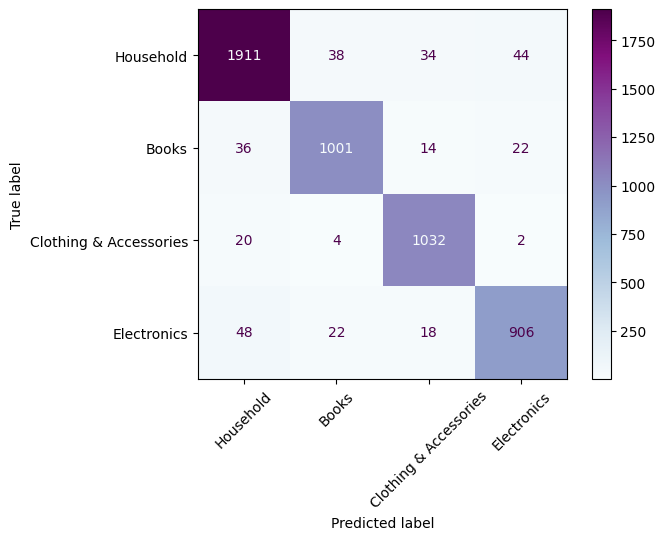

In [192]:
test_accuracy_prtr, test_loss_prtr, y_pred_list_prtr, y_test_list_prtr = mymodel.test(prtr_vec_model, DEVICE, test_loader, criterion)
make_some_metrics(test_accuracy_prtr, test_loss_prtr, y_test_list_prtr, y_pred_list_prtr, category, "pretrained_vectors_model")

Testing finished for trained_fasttext_model: Accuracy =  92.43%, Loss = 0.3440632002966143 
Classification report:
                         precision    recall  f1-score   support

             Household       0.93      0.94      0.93      2027
                 Books       0.89      0.94      0.91      1073
Clothing & Accessories       0.94      0.95      0.95      1058
           Electronics       0.94      0.85      0.90       994

              accuracy                           0.92      5152
             macro avg       0.93      0.92      0.92      5152
          weighted avg       0.92      0.92      0.92      5152



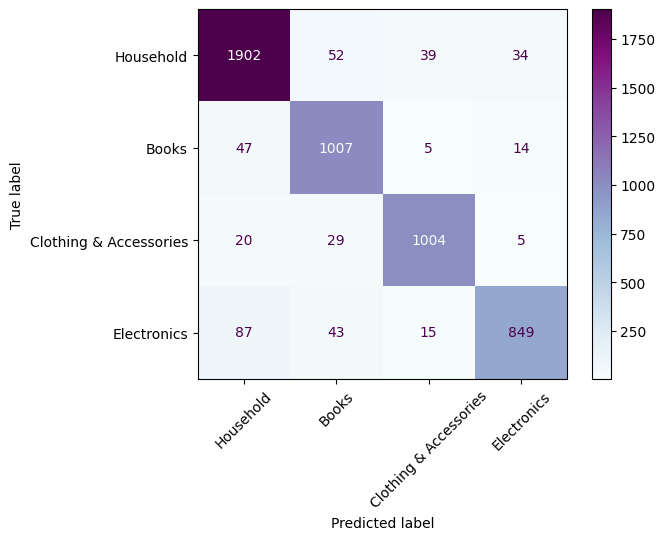

In [193]:
test_accuracy, test_loss, y_pred_list, y_test_list = mymodel.test(fsttxt_vec_model, DEVICE, test_loader, criterion)
make_some_metrics(test_accuracy, test_loss,y_test_list, y_pred_list, category, "trained_fasttext_model")

### Итог тестирования

Исходя из результатов кросс-валидации и тестирования, можно сделать вывод, что модель, использующая предобученные вектора показывает себя лучше, чем использующая обученные нами FastText вектора.

## Заключение
Мы получили оригинальную модель, которая работает хорошо, если к нам добавляют только продукты из описанных выше категорий :)

Дополнительно напишем функцию с понятный пользователю интерфейсом, для классификация одного отдельного текста.

In [194]:
def predict_single(text, model=prtr_vec_model, temp=5, inverse_category_list=category):
    text = text_preprocess(text)
    text_tok = edata.small_tokenize(text, vocabulary_to_int, max_len)
    splitted = text.split()
    actual_length = len(splitted)
    with torch.no_grad():
        x, h = text_tok.reshape(1, len(text_tok)).to(DEVICE),  model.init_hidden(1)
        out, _, attn_weights = model(x, h)
        attn_weights = attn_weights.cpu()
        temp = actual_length - 1 if temp > actual_length else temp
        _, important_tokens_base = torch.topk(attn_weights.squeeze(0)[:actual_length].unsqueeze(0), temp, dim=1)
        important_text = [splitted[token.to(int)] for token in important_tokens_base.squeeze(0) if token.to(int) in range(0, actual_length)]
        prediction = torch.argmax(out, dim=1)
        colors = sns.color_palette("plasma", n_colors=actual_length)
        plt.figure(figsize=(actual_length, actual_length/temp))
        bars = plt.bar(range(actual_length), attn_weights.squeeze(0)[:actual_length], color=colors)
        for i, bar in enumerate(bars):
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), splitted[i], ha='center', va='bottom', rotation=0, fontsize=8, color='black')
        plt.xlabel("Words")
        plt.ylabel("Attention")
        plt.show()
        return inverse_category_list[prediction.to(int)], important_text

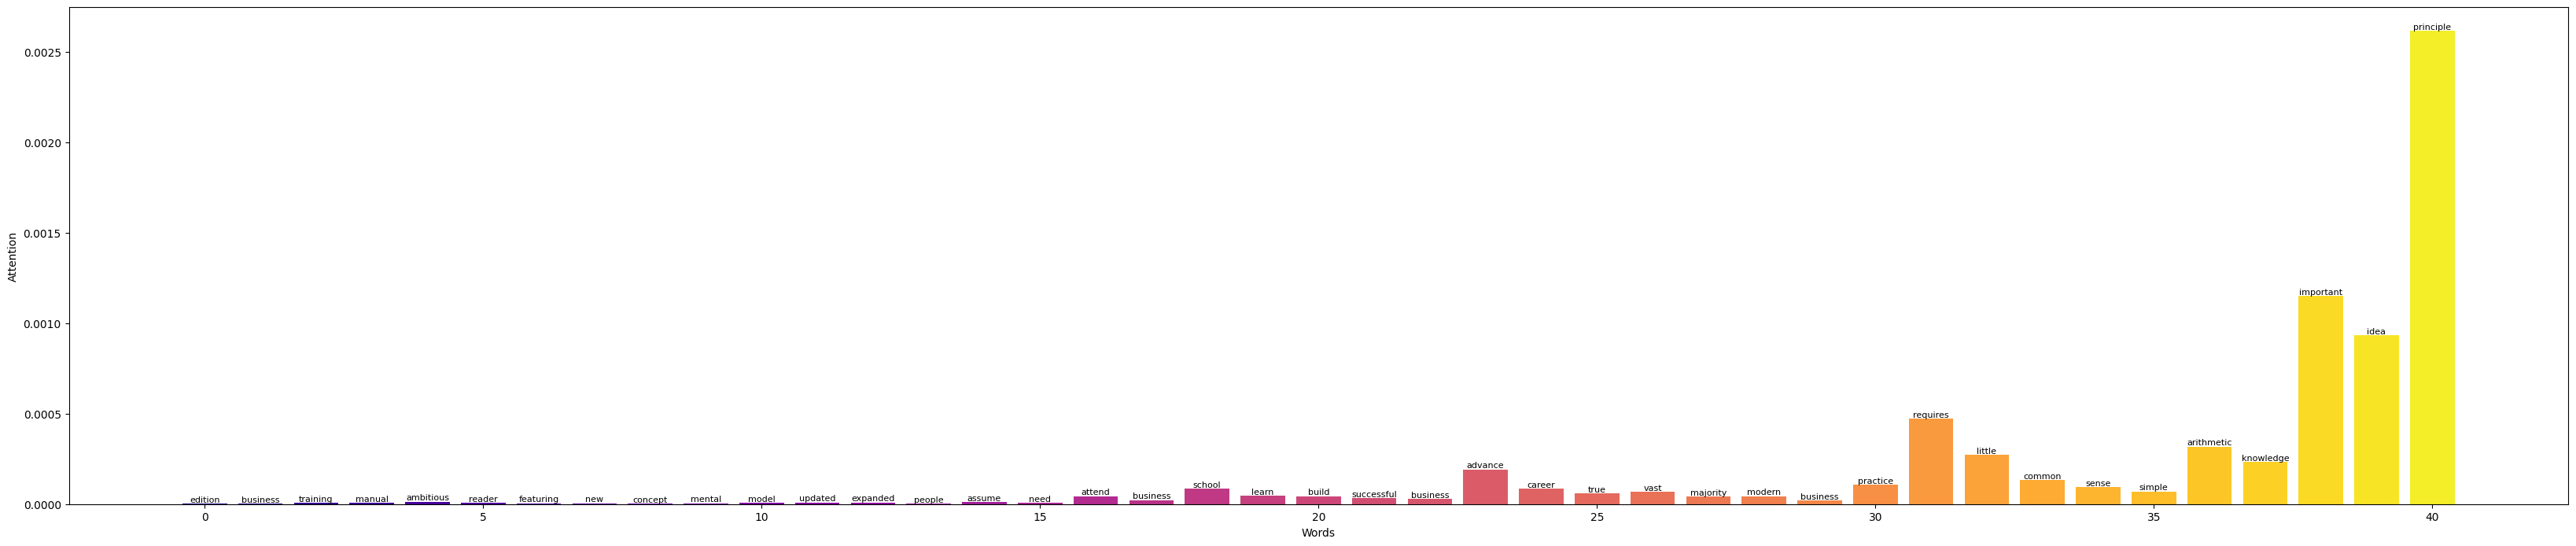

('Books', ['principle', 'important', 'idea', 'requires', 'arithmetic'])

In [195]:
predict_single('The 10th anniversary edition of the bestselling foundational business training manual for ambitious readers, featuring new concepts and mental models: updated, expanded, and revised.Many people assume they need to attend business school to learn how to build a successful business or advance in their career. Thats not true. The vast majority of modern business practice requires little more than common sense, simple arithmetic, and knowledge of a few very important ideas and principles')